# Project: Decision Trees

## Machine Learning, Winter 2017

### Name: [Jocelyn Shen, Nicholas Miklaucic, Kevin Sun, Darcy Meyer]


In this project, you'll perform the following tasks:
1. Construct a (Python) class `DecisionTree` which will serve as our first machine learning model.
2. Test it out on multiple datasets.  If you've done the above correctly, this shouldn't be hard!
3. Determine the effects of overfitting and attempt some solutions, discussing which seem to work best.

In [107]:
# Standard import statements:
from itertools import combinations, chain
from statistics import mean, median

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, r2_score

%matplotlib inline

plt.style.use("ggplot")

## `DecisionTree` Class

Construct a `DecisionTree` class in the cell below.  It should support the standard scikit-learn API: 

```
>>> X, y = <your_dataset>
>>> model = DecisionTree() # potentially with some parameters, if needed
>>> model.fit(X,y)
>>> model.predict(<new_sample_vector>)
1
>>> # If the model predicted your sample vector to be in class 1.
```

Note that your `predict` function should support either single predictions or multiple predictions, though you can force the user to do single predictions as a 2d array (single-row "multiple" predictions) so you only have one implementation to write.  What I mean by this is `model.predict(X)` should work (without error) to create all predictions for `y`.

You should construct some human-readable visualization of your model, simply from a printout.  This way you can tell if the model is being built the way you want.  The best way to do this is to implement the `__str__` method for your class.  Probably the easiest way to do this is to iterate through the tree in a "depth-first" fashion, and for each node, just print out some basic facts, like the number of elements in that node, or the indices of those elements in `X`, and the class assignment if it's a leaf node; also, make sure the indentation level of each node increases as its depth increases.  It might be helpful to have your nodes be more than just the bare minimum object (which would probably be a list of the indices of the rows in `X` for the items in your node).  To reiterate: this should NOT be a "beautiful" printout with lines like:
```
            root
           /    \
     child1      child2 
    /      \    /      \
...
```

Because that would get awkward fast.  What I'm imagining is:

```
root: <root_info>
  child1: <child1_info>
    grandchild1: <grandchild1_info>
      ...
    grandchild1: <grandchild2_info>
      ...
  child2: <child2_info>
    grandchild1: <grandchild1_info>
    grandchild1: <grandchild2_info>
```

By implementing this in `__str__` for your class, this will be the printout when you run:

```
model = DecisionTree(<whatever_you_need_to_do_to_create_your_model>)
model.fit(X,y)
print(model)
```

Recall the algorithm for fitting a decision tree:
1. Start with all your data samples in a single node.
2. For a given node, determine if you want to split at that node or not.  For now, this should just be a check to see if the node is "pure", meaning it only contains one class.  If you do decide to split it further, compute all possible splits of your data (all possible depth-1 subtrees).  For categorical variables, this should look like generating all pairs of combinations of classes.  For continuous or ordinal variables, sort the entries in that column, and then all possible splits involve cutting off at values between adjacent entries.  That is, if the entries in my continuous column are `[2.01, 3.425, 8.67, 493.6]`, then I have three splits, which are 
"$x_i\leq 2.01$", "$x_i\leq 3.425$", "$x_i\leq 8.67$".
3. Compute the change in Gini Impurity for each split, and choose the split that has the largest gain in information (most pure nodes).  Recall that the Gini Impurity for a node is 
$$ I = 1 - \sum_{\text{each class}} \left(\frac{\text{# of elements in that class}}{\text{# of elements in the node}}\right)^2$$
So then you want to maximize $I_\text{new_child1} + I_\text{new_child2} - I_\text{old}$; that is, choose the split with the largest value for that quantity (roughly interpretted as "information gain", though for the record the term "information gain" is used in a totally-synonymous-but-technically-different situation).
4. Repeat until all nodes are pure.
5. (Get the above working first, and then later:) prune the tree back to avoid overfitting your training data. (See below)

Note that your (Python) class should work for multi-class datasets (where you're trying to predict a `y` that has more than two classes).

In [108]:
"""This file implements a Node, a very simple class that simply has a left and a right child (both
Nodes or None), and a value.

Team: Jocelyn, Kevin, Nicholas
Author: Nicholas
"""

from functools import total_ordering  # neat trick


@total_ordering   # now every comparison function is defined. Neato!
class Node:
    """A Node of a tree."""

    def __init__(self, val, left, right):
        """Represents a node of a binary tree.  Val is the value this Node has: can be anything but should
        probably be hashable. Left and right are child Nodes, or None if this Node currently has no
        child there."""
        self.val = val
        self.left = left
        self.right = right

    def __str__(self):
        """Gives the Node's value and the values of its children."""
        return self.str_with_offset(self)

    @classmethod
    def str_with_offset(cls, node, offset=0):
        """Generates a string printout of the node, but adds a given offset to every line for
        alignment. If node is None, returns "None".
        """
        if node is None:
            return None
        ans = []  # create list of lines and join at the end
        ans.append("{}".format(str(node.val)))
        ans.append("\n{}==> {} ".format(' ' * offset, cls.str_with_offset(node.left, offset+4)))
        ans.append("\n{}==> {} ".format(' ' * offset, cls.str_with_offset(node.right, offset+4)))
        return ''.join(ans)

    def __repr__(self):
        """Gives the possible constructor."""
        return "Node({}, {}, {})".format(repr(self.val), repr(self.left), repr(self.right))

    def children(self):
        """Returns a tuple (L, R) of children, if both exist, otherwise just the one that does, or (). Note
        that this only returns a truthy value if the node has children: very useful!
        """
        if self.left is None:
            return () if self.right is None else (self.right,)
        elif self.right is None:
            return (self.left,)
        else:
            return (self.left, self.right)

    def all_children(self):
        """Returns a tuple (L, R) of children, but includes None instead of removing it."""
        return (self.left, self.right)

    def __eq__(self, other):
        """Uses the value, not the children, in comparison."""
        return self.val == other.val

    def __le__(self, other):
        """Uses the value, not the children, in comparison."""
        return self.val <= other.val


In [109]:
"""This is a class for encoding a split at a node of a decision tree in a class. That way, we can
represent more than one kind of split as both a class method function that splits data, and as a
logical condition in a human-readable format.

Team: Jocelyn, Kevin, Nicholas
Author: Nicholas
"""


class Split:
    """Represents a decision tree split. For now, this is just a less-than-or-equal-to test with a
    given value, but it could be extended in the future."""

    def __init__(self, predictor_name, val):
        """Val is the value that the split checks for <= relation to: for example, val=3.6 would make a
        Split to test x <= 3.6 for some input x. Predictor_name is the name of the predictor to
        test: for example, in a decision tree with a predictor y_1, you could use "y_1" as the
        predictorname to check if y_1 <= 3.6.

        """
        self.predictor_name = predictor_name
        self.val = val

    def __str__(self):
        """No explanation needed!"""
        return "{{{} <= {}}}".format(str(self.predictor_name), str(self.val))

    def __repr__(self):
        """Also no explanation needed."""
        return "Split({}, {})".format(repr(self.predictor_name), repr(self.val))

    def split(self, x, predictor_matrix, use_iloc=False):
        """Predictor_matrix must be a DataFrame with the given predictor name in it. X is then the index row
        to use for splitting, or, if use_iloc is True, the numerical index of a row (starting at
        0). Returns the result of the split applied to that particular entry.
        """
        if not hasattr(predictor_matrix[self.predictor_name], "iloc"):  # just a number
            return predictor_matrix[self.predictor_name] <= self.val
        
        if use_iloc:
            entry = predictor_matrix[self.predictor_name].iloc[x]
        else:
            entry = predictor_matrix[self.predictor_name][x]

        return entry <= self.val


In [110]:
"""This file provides a base Tree class for use with the DecisionTree class. It is simply a root
node (which has children, which have children, etc.), with some useful functions for doing things
you might want to do with a tree structure.

Team: Jocelyn, Kevin, Nicholas
Author: Nicholas
"""


from itertools import chain


class Tree:
    """Represents a binary tree."""
    def __init__(self, root_node):
        """Takes in a root node with children, who have children, and so on.  Traverses the node to build
        the tree, so make sure that you don't have an infinite loop!
        """
        self.root = root_node
        self.__calculate_node_list()

    def __calculate_node_list(self):
        """Internal method for reconstructing the nodes list when a change happens."""
        self.nodes = [self.root]
        children = self.root.children()
        self.nodes += list(children)

        while not all([c is None for c in children]):  # still values left
            new_children = []
            for child in children:
                if child is None:
                    new_children += [None, None]
                else:
                    new_children += list(child.all_children())
            children = new_children
            self.nodes += children

    def __str__(self):
        """Prints out a basic string representation."""
        return str(self.root)

    def __repr__(self):
        """Basic repr. Skips the recursive Node repr, as that could be EXTREMELY long."""
        return "Tree({})".format(repr(self.root.val))

    def breadth_first_iterable(self):
        """Returns an iterator over the tree in breadth_first order. There might a a lot of None
        values, because the entire tree is filled until the deepest node."""
        return iter(self.nodes)

    def __iter__(self):
        """Trying to iterate over this class should return the nodes in breadth_first order. Lots of
        Nones galore!"""
        return iter(self.nodes)

    def __getitem__(self, i):
        return self.nodes[i]

    def __depth_first_next(self, i):
        """Internal method for depth_first_iterable. Takes a 1-index to the nodes list and goes
        through the following recursive step: if the node has children, return the left child's
        result and the right child's result combined, with the current node at the beginning. If the
        node is a leaf, return itself."""
        node = self.nodes[i-1]
        l = self.__depth_first_next(i * 2) if node.left is not None else []
        r = self.__depth_first_next(i * 2 + 1) if node.right is not None else []
        return [i, *l, *r]

    def depth_first_iterable(self):
        """Returns an iterator over the tree in depth_first order. For example, a complete 3-deep binary
        tree numbered breadth-first 1, 2, 3, 4, 5, 6, 7 (1 -> 2 -> 4 is the left edge, for
        clarity) would return an iterator over the nodes in the order 1, 2, 4, 5, 3, 6, 7.

        """
        curr = 1   # "walk" down the tree using 1-indexed indices of the breadth-first children
        depth_first_nodes = self.__depth_first_next(curr)
        return [self.nodes[i - 1] for i in depth_first_nodes]  # subtract 1 to get the actual index

    def set_child(self, position, direction, child):
        """Sets a child at a given point on the tree (using breadth-first indexing). Child is the Node to
        add (or None to remove a child), position is the index of the parent, and direction is 0 for
        left side or 1 for right side. Raises ValueError if you attempt to delete a parent.

        As always, breadth-first indexing means 1-indexed as well.

        """
        parent = self.nodes[position-1]
        if child is None and parent.all_children()[direction] is not None:
            # can't delete a parent!
            raise ValueError("Can't delete a parent! Think of the children!")
        else:
            if direction == 0:
                parent.left = child
            else:
                parent.right = child
        self.__calculate_node_list()

    def index(self, node_val):
        """Gets the 1-indexed index of a given node value, the topmost furthest to the left if there
        are multiple. Ignores the children. Returns None if nothing was found."""
        for i, node in enumerate(self.nodes):
            if node.val == node_val:
                return i + 1
        return None

    def search_all(self, node_val):
        """Returns a list of all node indexes (1-indexed breadth-first) that have the given node value,
        ordered top-down and left-to-right.

        """
        ans = []
        for i, node in enumerate(self.nodes):
            if node.val == node_val:
                ans.append(i + 1)
        return ans

    def get_rows(self):
        """Gets a list of lists, where each list is the next-deepest row. Does not fill gaps with
        None values."""
        rows = []
        rows.append([self.root])
        children = self.root.children()
        while children:  # still values left
            rows.append(list(children))
            children = list(chain.from_iterable([child.children() for child in children]))
        return rows

    def get_row(self, row_depth):
        """Gets a list of all the nodes at a given height, where 0 is the root node. Does not fill
        gaps with None values. Wraps get_rows"""
        return self.get_rows()[row_depth]

    def depth(self):
        """Returns the length of the longest walk down the tree."""
        return len(self.get_rows())


In [111]:
"""This class creates a decision tree classifier for a given dataset."""

from copy import deepcopy

class DecisionTree:
    """Represents a decision tree classifier."""

    def __init__(self):
        """Creates a decision tree that can be fit to data."""
        self.tree = None

    def __str__(self):
        """Ignores DataFrames, only prints splits."""
        new_tree = deepcopy(self.tree)
        for node in [n for n in list(new_tree) if n is not None]:
            if len(node.val) == 1 or node.val[1] is None:
                node.val = "<data>"
            else:
                node.val = str(node.val[1])
        return str(new_tree)

    @classmethod
    def gini_vector(cls, col):
        """Given a single input Series with a single column filled with the digits 0-n, computes the
    Gini impurity."""
        impurity = 0
        n = len(set(col))
        if n <= 1:  # sets without any elements or with a single class are pure by default
            return 0

        for i in range(n):
            p_class = sum(col.map(lambda x: 1 if x == i else 0)) / len(col)
            impurity += p_class ** 2

        return 1 - impurity

    @classmethod
    def gini(cls, classes):
        """Computes the Gini impurity of the given data, a class vector or matrix in 0's and 1's or any
    additional amount of classes.
        """
        return classes.apply(cls.gini_vector).sum()

    def gen_splits(self, data, classes):
        """Given input data and a corresponding matrix of classes, returns a list of Split objects
        corresponding to all the possible splits of that dataset at that time."""
        splits = []
        for predictor_name in data.columns:
            pred = data[predictor_name]
            # generate every possible split cutoff that would mean something
            # also, remove duplicates
            cutoffs = list(set(pred))
            cutoffs = [c for c in cutoffs if c != max(cutoffs)]  # remove topmost element
            splits += [Split(predictor_name, cutoff) for cutoff in cutoffs]
        return splits

    def execute_split(self, data, classes, split):
        """Given data with associated classes and split data, returns a tuple ((data_false, classes_false)
        (data_true, classes_true)) with the entries that are false and the entries that satisfy the
        split.
        """

        # generate indices of cutoffs instead of just the data to preserve class data
        good_indices = [i for i in range(data.shape[0]) if split.split(i, pd.DataFrame(data), True)]
        bad_indices = [i for i in range(data.shape[0]) if i not in good_indices]

        good = (data.iloc[good_indices, :], classes.iloc[good_indices, :])
        bad = (data.iloc[bad_indices, :], classes.iloc[bad_indices, :])
        return (bad, good)

    def test_split(self, data, classes, split):
        """Given data with associated classes and a split, returns the sum of the Gini impurity of
        the child nodes of this split if it is effected."""

        left, right = self.execute_split(data, classes, split)
        return self.gini(left[1]) + self.gini(right[1])

    def not_overfit(self, data, classes, split, k=0.05):
        """This method can be overridden or replaced to change how much the fitting algorithm prunes the
        tree. The default is to require that at least a fraction of the input be separated (the
        defaut is 5%)."""
        left, right = self.execute_split(data, classes, split)
        
        return k <= left[0].shape[0] / data.shape[0] <= 1 - k

    def create_split(self, pos, prune_func):
        """Given a position in the decision tree (1-based breadth-first indexing), first checks to see if
        the data is pure. If it is, then it sets both children to None and stops. Otherwise, it
        computes the split that minimizes the Gini impurity for each child node and executes it,
        creating two new children that are the results of the split (left for false, right for
        true).

        Prune_func is the pruning function to determine whether a split is valid.
        """
        # print("Creating split at position {}".format(pos))

        node = self.tree[pos-1]
        node_val = node.val[0]  # the tuple (data, classes)
        curr_gini = self.gini(node_val[1])

        if curr_gini == 0:  # data is pure
            self.tree.set_child(pos, 0, None)
            self.tree.set_child(pos, 1, None)  # make this a leaf
            return None  # we're done here!
        else:  # generate possible splits
            splits = self.gen_splits(*node_val)
            splits = [split for split in splits if prune_func(*node_val, split)]
            # print(splits)
            if len(splits) == 0:  # no splits that separate into at least one class
                self.tree.set_child(pos, 0, None)
                self.tree.set_child(pos, 1, None)
                return None
            # find the best one
            best = min(splits, key=lambda split: self.test_split(*node_val, split))
            # print(sorted(splits, key=lambda split: self.test_split(*node_val, split))[:5])
            if len(node.val) == 1:  # no split in the node yet
                node.val.append(best)
            else:  # overwrite a split
                node.val[1].append(best)
            # execute it
            left, right = self.execute_split(*node_val, best)
            # print(best)
            # print(left[0].shape[0], right[0].shape[0])

            self.tree.set_child(pos, 0, Node([left], None, None))
            self.tree.set_child(pos, 1, Node([right], None, None))

    def recursively_create_splits(self, pos, prune_func):
        """For the current Node, recursively splits all of its children (generating them as it goes) until
        all of the leaves are pure, returning None. Prune_func is the function to reduce
        overfitting.

        """
        if pos > len(list(self.tree)) or self.tree[pos-1] is None:  # we stop here
            return None
        else:  # create two children and recurse to split them
            self.create_split(pos, prune_func)
            self.recursively_create_splits(pos * 2, prune_func)  # left child
            self.recursively_create_splits(pos * 2 + 1, prune_func)  # right child
            return None

    def fit(self, X, y, pruning_func=None):
        """Fits a given input matrix to a given output vector using a decision tree. X should be a DataFrame
        of numerical variables with any index or column names. y should be a vector or matrix with
        the same height as X, as many columns as classes to predict, and each column should be a
        list of 0's and 1's for a given class. The pruning_func parameter can be filled with any
        function that takes in three arguments (data, classes, split) and returns True if that split
        is allowed and False otherwise. The default, specified with None, is to only use splits that
        separate 5% of the input.

        """
        # start with just the entire dataset at the root, with no split
        # I'm going to represent a single node of a tree as a value [(data, classes), split]
        # where data and classes are "what's left" and split is the Split function that gives the
        # left and right children, or None if the data is pure or the splits have stopped
        if pruning_func is None:  # use default
            pruner = self.not_overfit
            
        self.tree = Tree(Node([(X, y)], None, None))
        self.recursively_create_splits(1, prune_func=pruner)  # pretty anticlimactic
        return None

    def __predict_vec(self, X):
        """Given an input vector with the required number of predictors, returns an output vector
        y_hat representing the predicted classes for all of the classes it was fit to."""

        if self.tree is None:  # nothing to predict with!
            raise ValueError("Must fit to a model before prediction!")

        curr_pos = 1
        while True:  # loop until something is returned
            curr_node = self.tree[curr_pos-1]
            curr = curr_node.val
            if len(curr) == 1 or curr[1] is None:  # no split, so must be pure or close
                # return the mean of the classes, rounding to integers
                # this way, even with non-pure pruned leaves you still get a result
                if not hasattr(curr[0][1], "__len__"):  # single number
                    return curr[0][1]  # we're done
                else:  # lots of values
                    if len(curr[0][1].shape) > 1:  # 2D array, so use array functions
                        return curr[0][1].mean().round()
                    else:  # just get the mean and use basic round, not a method
                        return int(curr[0][1].mean())
            else:  # go down to the correct child and try again
                if curr[1].split(0, X, use_iloc=True):  # split with the input data

                    curr_pos = curr_pos * 2 + 1  # right child

                else:  # left child, because the Split returned False
                    curr_pos *= 2

            # now, just repeat until we get to a leaf!

    def predict(self, X):
        """For every row in X, predicts the classes and returns a matrix Y representing the
        predicted classes."""
        if len(X.shape) == 1:  # single row
            return self.__predict_vec(X)

        return X.apply(self.__predict_vec, axis=1)

    def __score_col(self, col1, col2):
        """Returns the accuracy score for two Series."""
        correct = 0
        for i in range(len(col1)):
            if col1.iloc[i] == col2.iloc[i]:
                correct += 1
        return correct / len(col1)

    def score(self, X, true_y):
        """Gets the accuracy score of the classifier given the X as input and with true_y as the
        actual values. If there are multiple classes, returns an iterable of each accuracy score."""

        preds = self.predict(X)
        if len(preds.shape) >= 2 and preds.shape[1] > 1:  # multiple classes
            scores = []
            for colname in preds:
                scores.append(self.__score_col(preds[colname], true_y[colname]))
            return scores
        else:  # just one class
            if isinstance(preds, pd.DataFrame):  # convert to Series
                converted_pred = preds.iloc[:, 0]
            else:
                converted_pred = preds

            if isinstance(true_y, pd.DataFrame):  # convert to Series
                converted_true = true_y.iloc[:, 0]
            else:
                converted_true = true_y

            return self.__score_col(converted_pred, converted_true)


To test out your code, here's a simple dataset.  You could check it by hand if you need to debug.  You're trying to predict whether an animal is a mammal or not (the class label).

In [112]:
mat = [["human", "warm-blooded", "yes", "no", "no", "yes"],
       ["pigeon", "warm-blooded", "no", "no", "no", "no"],
       ["elephant", "warm-blooded", "yes", "yes", "no", "yes"],
       ["leopard shark", "cold-blooded", "yes", "no", "no", "no"],
       ["turtle", "cold-blooded", "no", "yes", "no", "no"],
       ["penguin", "cold-blooded", "no", "no", "no", "no"],
       ["eel", "cold-blooded", "no", "no", "no", "no"],
       ["dolphin", "warm-blooded", "yes", "no", "no", "yes"],
       ["spiny anteater", "warm-blooded", "no", "yes", "yes", "yes"],
       ["gila monster", "cold-blooded", "no", "yes", "yes", "no"]]

df = pd.DataFrame(mat, columns=["Name",
                                "Body Temperature",
                                "Gives Birth",
                                "Four-legged",
                                "Hibernates",
                                "Class Label"])

### Accuracy Score, Confusion Matrix, Precision, and Recall

Add some classification metrics to your models, like the `accuracy_score` and `confusion_matrix`.  Add additionally [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall), and explain what those are.



In [113]:
# test_real is an array of the real values of the testing data
# test_results is an array of predictions from the testing data
def accuracy_score(test_real, test_results):
    count = 0
    for i in range(len(test_real)):
        if test_real[i] == test_results[i]:
            count +=1
    return float(count)/len(test_results)

In [114]:
def confusion_matrix(test_real,test_results):
    true_n = 0
    true_p = 0
    false_n = 0
    false_p = 0
    for i in range(len(test_real)):
        p = test_results[i]
        r = test_real[i]
        if  p == 0 and r == 0:
            true_n += 1
        elif p == 0 and r == 1:
            false_n += 1
        elif p == 1 and r == 0:
            false_p += 1
        elif p == 1 and r == 1:
            true_p += 1
    return np.matrix([[true_p,false_p],[false_n,true_n]])

Precision is the fraction of elements that are relevant (for example if 5 chess pieces in a board of 10 pieces are identified as black, but only 3 of them are actually black, then the precision is 3/5)
Recall is the fraction of relevant instances that are retrieved (in this example, 5/10)

In [115]:
def precision(test_real, test_results):
    true_n = 0
    true_p = 0
    false_n = 0
    false_p = 0
    for i in range(len(test_real)):
        p = test_results[i]
        r = test_real[i]
        if  p == 0 and r == 0:
            true_n += 1
        elif p == 0 and r == 1:
            false_n += 1
        elif p == 1 and r == 0:
            false_p += 1
        elif p == 1 and r == 1:
            true_p += 1
    return float(true_p)/(true_p + false_p)

In [116]:
def recall(test_real, test_results):
    true_n = 0
    true_p = 0
    false_n = 0
    false_p = 0
    for i in range(len(test_real)):
        p = test_results[i]
        r = test_real[i]
        if  p == 0 and r == 0:
            true_n += 1
        elif p == 0 and r == 1:
            false_n += 1
        elif p == 1 and r == 0:
            false_p += 1
        elif p == 1 and r == 1:
            true_p += 1
    return float(true_p)/(true_p + false_n)

## Try it out on multiple datasets

Feel free to split these amongst your group mates, then consolodate it into one notebook.




### Mammals Dataset

1) The dataset `X` above.


In [117]:
X = df.loc[:, ["Body Temperature", "Gives Birth", "Four-legged", "Hibernates"]]
y = df.loc[:, "Class Label"]

X["Body Temperature"] = X["Body Temperature"].apply(lambda x: 1 if x == "warm-blooded" else 0)
for col in X.columns[1:]:
    X[col] = X[col].apply(lambda x: 1 if x == "yes" else 0)

y = pd.DataFrame(y.apply(lambda x: 1 if x == "yes" else 0))


tree = Tree(Node('a',
                 Node('b', None,
                      Node('c', None,
                           Node('d', None, None))),
                 Node('e', None, None)))


def print_tree(t):
    print('\n'.join([repr(x) for x in list(t)]))

print()
print(tree)
tree.set_child(5, 0, Node('f', None, None))
print()
print(tree)



dt = DecisionTree()
dt.fit(X, y)
pred = []
for i in range(len(df)):
    x_pred = X.iloc[i]
    pred.append(dt.predict(x_pred)['Class Label'])
    print(dt.predict(x_pred))



a
==> b
    ==> None 
    ==> c
        ==> None 
        ==> d
            ==> None 
            ==> None    
==> e
    ==> None 
    ==> None  

a
==> b
    ==> None 
    ==> c
        ==> f
            ==> None 
            ==> None  
        ==> d
            ==> None 
            ==> None    
==> e
    ==> None 
    ==> None  
Class Label    1.0
dtype: float64
Class Label    0.0
dtype: float64
Class Label    1.0
dtype: float64
Class Label    0.0
dtype: float64
Class Label    0.0
dtype: float64
Class Label    0.0
dtype: float64
Class Label    0.0
dtype: float64
Class Label    1.0
dtype: float64
Class Label    1.0
dtype: float64
Class Label    0.0
dtype: float64


In [118]:
test_r = [val[0] for val in y.values]

In [119]:
confusion_matrix(test_r,pred)

matrix([[4, 0],
        [0, 6]])

In [120]:
accuracy_score(test_r,pred)

1.0

In [121]:
recall(test_r,pred)

1.0

In [122]:
precision(test_r,pred)

1.0

### Iris Dataset

2) To double check that your multi-class support is working, use the [iris dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris).  Plot some decision boundaries of the classifier you make in all the pairs of dimensions in your scatter plots.



In [123]:
df = pd.read_csv('iris.data', names = ["sepal-length", "sepal-width", "petal-length", "petal-width", "class"])
iris_types = np.unique(df['class'])
df['class'] = df['class'].map({iris_types[0]:0,iris_types[1]:1,iris_types[2]:2})
df.head()

,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [124]:
from sklearn.cross_validation import train_test_split

In [125]:
dt = DecisionTree()
X = df[['sepal-length','sepal-width','petal-length','petal-width']]
y = df['class']

iris_x_train, iris_x_test, iris_y_train, iris_y_test = train_test_split(X.values, y.values, test_size=0.4)

iris_x_train = pd.DataFrame(iris_x_train, columns=X.columns)
iris_x_test = pd.DataFrame(iris_x_test, columns=X.columns)

iris_y_train = pd.DataFrame({'type': iris_y_train})
iris_y_test = pd.DataFrame({'type': iris_y_test})

dt = DecisionTree()
dt.fit(iris_x_train, iris_y_train)
y_bar = dt.predict(iris_x_test)
print(dt.score(iris_x_test, iris_y_test))

0.8833333333333333


In [157]:
acc_scores = []
for num_nodes in range(1, 31, 5):
    fixed_dt = FixedNodesDecisionTree(num_nodes)
    fixed_dt.fit(iris_x_train, iris_y_train)
    acc_scores.append((num_nodes, fixed_dt.score(iris_x_test, iris_y_test)))

acc_scores = np.array(acc_scores)
print(acc_scores)

[[  1.           0.51666667]
 [  6.           0.91666667]
 [ 11.           0.91666667]
 [ 16.           0.91666667]
 [ 21.           0.91666667]
 [ 26.           0.91666667]]


In [162]:
x_ = (acc_scores[:,0])
y_ = (acc_scores[:,1])

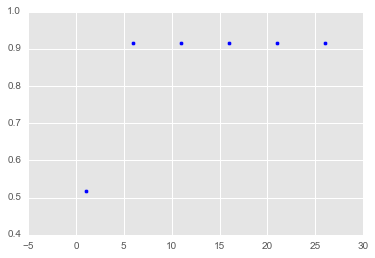

In [164]:
plt.scatter(x_,y_)

In [126]:
test_r = [x[0] for x in iris_y_test.values]
pred = [x[0] for x in y_bar.values]

In [127]:
accuracy_score(test_r,pred)

0.8833333333333333

In [128]:
confusion_matrix(test_r,pred)

matrix([[14,  1],
        [ 1, 16]])

In [129]:
precision(test_r,pred)

0.9333333333333333

In [130]:
recall(test_r,pred)

0.9333333333333333

In [131]:
x_col = X.columns

The following code is modified from http://scikit-learn.org/stable/auto_examples/tree/plot_iris.html

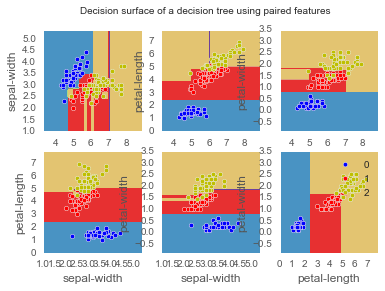

In [132]:
import matplotlib.pyplot as plt

# Parameters
n_classes = 3
plot_colors = "bry"
plot_step = 0.02


for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    
    X1 = X.values[:, pair]
    y1 = y.values

    # Train
    clf = DecisionTreeClassifier().fit(X1, y1)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
    y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.xlabel(x_col[pair[0]])

    plt.ylabel(x_col[pair[1]])
    plt.axis("tight")

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X1[idx, 0], X1[idx, 1], c=color, label=y.unique()[i],
                    cmap=plt.cm.Paired)

    #plt.axis("tight")

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend()
plt.show()

### Constructed Dataset

3) Take a look at some of the [dataset constructors in scikit-learn](http://scikit-learn.org/stable/datasets/#sample-generators).  Pick one that will allow you to generate a dataset that has $\geq 4$ features, and multiple classes ($\geq 3$); but also make sure that when I run your code with some tweaked numbers from these, it will still work.



In [133]:
from sklearn.datasets import make_multilabel_classification
n_f = 5
n_c = 3
X,Y = make_multilabel_classification(n_samples=50, n_features=n_f, n_classes=n_c)
Y = np.sum(Y, axis=1)
Y = pd.DataFrame(Y, columns = ['class'])
df = pd.concat([pd.DataFrame(X),Y], axis = 1)
df.head()

,0,1,2,3,4,class
0,8.0,19.0,10.0,5.0,12.0,1
1,9.0,6.0,14.0,3.0,13.0,2
2,7.0,11.0,10.0,7.0,19.0,3
3,11.0,20.0,9.0,11.0,18.0,1
4,14.0,12.0,8.0,12.0,10.0,3


In [134]:
x_col_names = [(n) for n in range(n_f)]

In [135]:
dt = DecisionTree()

X = df[x_col_names]
y = df['class']

x_train, x_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.4)

x_train = pd.DataFrame(x_train, columns=X.columns)
x_test = pd.DataFrame(x_test, columns=X.columns)

y_train = pd.DataFrame({'type': y_train})
y_test = pd.DataFrame({'type': y_test})

dt = DecisionTree()
dt.fit(x_train, y_train)
y_bar = dt.predict(x_test)
print(dt.score(x_test, y_test))

0.45


In [136]:
test_r = [x[0] for x in y_test.values]
pred = [x[0] for x in y_bar.values]

In [137]:
accuracy_score(test_r,pred)

0.45

In [138]:
confusion_matrix(test_r,pred)

matrix([[5, 0],
        [1, 1]])

In [139]:
precision(test_r,pred)

1.0

In [140]:
recall(test_r,pred)

0.8333333333333334

### Titanic Dataset

4) Kaggle is a website which offers machine learning challenges to anyone with an interest in working on them, some of which have real prizes associated with them.  The [Titanic challenge](https://www.kaggle.com/c/titanic/data) is a tutorial challenge which has you attempting to predict whether someone did or did not die on board the Titanic, based on their criteria.  In order to download the dataset, you'll need to make an account, and agree to some scary-sounding agreement about not sharing their data with the world (to make their legal team happy).  Do only the minimum of data cleanup on it, trash the name column (unless you want to get really fancy), and fit a decision tree to the dataset.  Make sure to save some data for testing purposes.



In [152]:
df = pd.read_csv('train.csv')
df = df.drop('Name', 1)
df.Sex = df.Sex.map({'male':0, 'female': 1})
df.Embarked = df.Embarked.map({'S':0,'C':1})
df = df.dropna()

In [142]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,1,38.0,1,0,PC 17599,71.2833,C85,1.0
3,4,1,1,1,35.0,1,0,113803,53.1000,C123,0.0
6,7,0,1,0,54.0,0,0,17463,51.8625,E46,0.0
10,11,1,3,1,4.0,1,1,PP 9549,16.7000,G6,0.0
11,12,1,1,1,58.0,0,0,113783,26.5500,C103,0.0


In [153]:
X = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
y = df['Survived']

In [154]:
dt = DecisionTree()

x_train, x_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.4)

x_train = pd.DataFrame(x_train, columns=X.columns)
x_test = pd.DataFrame(x_test, columns=X.columns)

y_train = pd.DataFrame({'type': y_train})
y_test = pd.DataFrame({'type': y_test})

In [145]:
dt = DecisionTree()
dt.fit(x_train, y_train)

In [146]:
y_bar = dt.predict(x_test)
print(dt.score(x_test, y_test))

0.7671232876712328


### Noisy Dataset

6) For the dataset `noisy_dataset.csv`, available on Canvas in `Files`, put the data into `test` and `train` sets, and then construct a family of decision trees with an increasing number of nodes, say from 3 up to something large (large enough that the test accuracy starts getting awful). Plot a pair of curves on the same axes: (# of nodes) vs. model accuracy (training and test).  Discuss which models make the best predictors.

In [149]:
df = pd.read_csv("noisy_dataset.csv")
X = df[['x_1', 'x_2']]
y = df['y']
df.head()

,Unnamed: 0,x_1,x_2,y
0,0,0.169124,6.545124,0.0
1,1,1.244786,7.681310,0.0
2,2,0.926550,5.063571,0.0
3,3,6.298943,7.374926,0.0
4,4,4.479117,8.684585,0.0


Note: runtime extremely long on this one, so it didn't finish running

In [165]:
dt = DecisionTree()

x_train, x_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.4)

x_train = pd.DataFrame(x_train, columns=X.columns)
x_test = pd.DataFrame(x_test, columns=X.columns)

y_train = pd.DataFrame({'type': y_train})
y_test = pd.DataFrame({'type': y_test})

dt = DecisionTree()
dt.fit(x_train, y_train)
y_bar = dt.predict(x_test)
print(dt.score(x_test, y_test))

KeyboardInterrupt: 

In [ ]:
test_r = [x[0] for x in y_test.values]
pred = [x[0] for x in y_bar.values]

In [ ]:
accuracy_score(test_r,pred)

In [ ]:
confusion_matrix(test_r,pred)

In [ ]:
precision(test_r,pred)

In [ ]:
recall(test_r,pred)

In [156]:
class FixedNodesDecisionTree(DecisionTree):
    """A decision tree with a fixed amount of splits."""
    def __init__(self, num_nodes):
        """Num_nodes is the number of nodes allowed."""
        self.num_nodes = num_nodes
        self.curr_nodes = 0  # no nodes currently
        super().__init__()

    def not_overfit(self, data, classes, split):
        """Does the parent's not_overfit and also checks if the global amount of nodes has increased
        too far, in which case it returns False."""
        return self.curr_nodes < self.num_nodes

    def create_split(self, pos, prune_func):
        """Does the super's version, and then increments curr_nodes."""
        node = self.tree[pos-1]
        node_val = node.val[0]  # the tuple (data, classes)
        curr_gini = self.gini(node_val[1])

        if curr_gini == 0:  # data is pure
            self.tree.set_child(pos, 0, None)
            self.tree.set_child(pos, 1, None)  # make this a leaf
            return None  # we're done here!
        else:  # generate possible splits
            splits = self.gen_splits(*node_val)
            splits = [split for split in splits if prune_func(*node_val, split)]
            # print(splits)
            if len(splits) == 0:  # no splits that separate into at least one class
                self.tree.set_child(pos, 0, None)
                self.tree.set_child(pos, 1, None)
                return None
            # find the best one
            best = min(splits, key=lambda split: self.test_split(*node_val, split))
            # print(sorted(splits, key=lambda split: self.test_split(*node_val, split))[:5])
            if len(node.val) == 1:  # no split in the node yet
                node.val.append(best)
            else:  # overwrite a split
                node.val[1].append(best)
            # execute it
            left, right = self.execute_split(*node_val, best)

            # ONLY CHANGED PART
            # just increment the number of nodes
            self.curr_nodes += 1

            # print(best)
            # print(left[0].shape[0], right[0].shape[0])

            self.tree.set_child(pos, 0, Node([left], None, None))
            self.tree.set_child(pos, 1, Node([right], None, None))

In [ ]:
#To use the fixed nodes class:
acc_scores = []
for num_nodes in range(1, 31, 5):
    fixed_dt = FixedNodesDecisionTree(num_nodes)
    fixed_dt.fit(x_train, y_train)
    acc_scores.append((num_nodes, fixed_dt.score(x_test, y_test)))

acc_scores = np.array(acc_scores)
print(acc_scores)

To plot the nodes versus the model accuracy

In [ ]:
x_ = (acc_scores[:,0])
y_ = (acc_scores[:,1])
plt.scatter(x_,y_)

## Compare to scikit-learn's `DecisionTreeClassifier` class

It should come as no surprise to you that scikit-learn has a [decision tree class](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier).  Compare your constructed class to theirs in terms of their functionality, what attributes and constructor-arguments does their decision tree class have that yours does not?

The DecisionTreeClassifier class from sci-kit learn comes with a multitude constructor arguments and attributes that our DecisionTree class does not have. The methods we had were pretty similar to their methods, for example "fit" to build the decision tree classifier from the training set (X, y) and "predict" to predict the class for the X inputs.

### Sci-kit Constructor parameters
    
criterion="string", where "string" default is "gini"
This argument measures the quality of a split, including “gini” for the Gini impurity and “entropy” for the information gain.

splitter : string, optional (default=”best”)
The strategy used to choose the split at each node, for example, “best” to choose the best split and “random” to choose the best random split.

max_features : int, float, string or None, optional (default=None)
The number of features to consider when looking for the best split.

max_depth : int or None, optional (default=None)
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

min_samples_split : int, float, optional (default=2)
The minimum number of samples required to split an internal node.

min_samples_leaf : int, float, optional (default=1)
The minimum number of samples required to be at a leaf node.

min_weight_fraction_leaf : float, optional (default=0.)
The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node.

max_leaf_nodes : int or None, optional (default=None)
Thie argument is used to grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined based on lowest impurity.

class_weight : dict, list of dicts, “balanced” or None, optional (default=None)
This argument represents weights associated with classes in the form {class_label: weight}.

random_state : int, RandomState instance or None, optional (default=None)
If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.

min_impurity_split : float, optional (default=1e-7)
Threshold for early stopping in tree growth. A node will split if its impurity is above the threshold, otherwise it is a leaf.

### Sci-kit Attributes

classes_ : array of shape = [n_classes] or a list of such arrays
Single output problems: The classes labels.
Multi-output problems: A list of arrays of class labels

feature_importances_ : array of shape = [n_features]
"The feature importances. The higher, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance [R245]."

max_features_ : int,
The inferred value of max_features.

n_classes_ : int or list
Single output problems: The number of classes,
Multi-output problems: A list containing the number of classes for each output.

n_features_ : int
Number of features when fit is performed.

n_outputs_ : int
Number of outputs when fit is performed.

tree_ : Tree object

## Overfitting and what to do about it

What we saw (hopefully!) in dataset 6 above is called __overfitting__, meaning our model is learning the noise in the training data.  This weakens the models predictive power.  There are many options to reduce overfitting, here are a few.  Implement at least one of them, until you have something that makes your models noticeably better.

* Add a stopping condition: 
 * stop splitting off more nodes when a node reaches either a minimal number of items per node _or_ is a pure node,
 * stop splitting by not allowing any child nodes to go below a minimum number of nodes,
 * stop splitting when you've reached some maximum depth.
* After fitting a deep, overfit tree, use a __validation__ set to _prune_ the tree: remove nodes by rejoining children into parents, then test them against the validation set to see if the pruned tree was better.  Do this until you stop seeing improvements on the validation set.  Here a validation set means a third split of data, different from test and train.  It's different from the training set because you're not training the model on it, but it's also not testing data because you're changing your model based on knowledge gained from the dataset.  It's somewhere in between.  Feel free to ask me about _cross-validation_ as well, and how you could use that instead.  We'll talk about it eventually, but I don't want to add more to this project than is already here.

__Explain to me what you did, and where it shows up in your code (for example, is it in your class definition?).__

We added a stopping method in the decision tree class. It is in the method, not_overfit. The default is to require that at least a fraction of the input be separated (the defaut is 5%)
left, right = self.execute_split(data, classes, split)
return k <= left[0].shape[0] / data.shape[0] <= 1 - k

## Possible extensions

Here are two extensions of the `DecisionTree` class that you made.  They are entirely optional, so don't feel you need to do them!

* In reality, people use decision trees on a limited basis, typically only when model interpretability is forced by government institutions (so, this happens a lot with banks, for example).  What you normally do is build a __forest__ of trees, that is, a collection of several trees (a common number is 50-500 trees), and then have them vote.  However, if you let your trees build themselves from the same exact datasets each time, they will be roughly the same, and the power of this voting model will be irrelevant.  Thus, one extremely common model is called the __Random Forest__ classifier: give each tree only a subset of the features to train from, don't prune at all (allow them to overfit on that subset), and then have them vote.  This increases the variance of the distribution of tree votes, which helps to average out the errors.  Create a new Python class that builds this classification model.  Note that Random Forests are a current industry favorite (among other things, like support vector machines, boosted trees, and neural networks), meaning if you do this you'll have created a model capable of hacking it with some of the best!

* Scikit-learn's `DecisionTreeClassifier` has a somewhat pretty visualization of the tree that can be exported using the library `GraphViz`.  There are python wrappers to this module, the most common is `pydot`.  Using these libraries, or similar ones, add the functionality of constructing an attractive visualization of your decision tree class.

In [ ]:
"""This file implements a subclass of DecisionTree that has one small caveat: when it makes a split,
it chooses a random subset of the features it has to make a split with, thereby reducing the tree's
tendency to be dominated by a few strong predictors.
Team: Jocelyn, Kevin, Nicholas
Author: Nicholas
"""

from random import sample


class RandomDecisionTree(DecisionTree):
    """A random forest decision learner."""
    def __init__(self):
        """Initializes a RandomDecisionTree ready for fitting."""
        super().__init__()

    def gen_splits(self, data, classes):
        """Generates all possible splits using only the square root of the number of available
        features."""
        splits = []
        for predictor_name in sample(data.columns, int(len(data.columns) ** (0.5))):
            pred = data[predictor_name]
            # generate every possible split cutoff that would mean something
            cutoffs = list(pred)
            cutoffs = [c for c in cutoffs if c != max(cutoffs)]  # remove topmost element
            splits += [Split(predictor_name, cutoff) for cutoff in cutoffs]
        return splits

    def fit(self, X, y):
        """Does no pruning, just the custom feature bagging. Fits the tree to predict the classes in
        y given the features in X."""
        super().fit(X, y)

In [ ]:
"""This file uses a random forest, a bunch of individual unpruned decision trees with access to only
some of the features. Final classification is then done by majority vote, to remove overfitting
noise and make the model extremely robust.
There's one interesting addendum to this: in a random forest decision tree, making a split is only
done with a subset of the features available at every step. This way, strong predictors don't
dominate every tree they appear in and overly couple the trees.
Team: Jocelyn, Kevin, Nicholas
Author: Nicholas
"""

from itertools import combinations
from random import sample

import pandas as pd


class RandomForestClassifier:
    """A random forest classifier."""
    def __init__(self, n, b, n_ratio=True, b_ratio=True):
        """Initializes a bare random forest classifier. N is the number of elements to bootstrap from the
        training data, or a ratio of the total data size if n_ratio is True. B is the number of
        trees to use when classifying. If b_ratio is True, b will instead be a ratio of the total
        data input dimensionality.
        """
        self.n = n
        self.n_ratio = n_ratio
        self.b_ratio = b_ratio
        self.b = b
        self.trees = []

    @classmethod
    def get_all_subsets(self, items):
        """Returns a list of every subset of the given input."""
        subsets = []
        for i in range(1, len(items)+1):
            subsets += [combo for combo in combinations(items, i)]
        return subsets

    @classmethod
    def get_random_samples(cls, choices, n):
        """Draws n different subsets of choices and returns them as a list."""
        return sample(cls.get_all_subsets(choices), n)

    def fit(self, X, y):
        """Fits a random forest classifier on X mapping to Y, a vector with the same height but
        classes instead of predictors."""
        
        # get correct number of trees
        tree_num = self.b if not self.b_ratio else int(self.b * X.shape[1])

        # get the right number of samples of features
        feature_samples = self.get_random_samples(X.columns, tree_num)
        # get the right number of samples of data
        bootstrap_size = self.n if not self.n_ratio else int(self.n * X.shape[0])
        bootstraps = [sample(range(X.shape[0]), bootstrap_size) for i in range(tree_num)]

        data_subsets = [(X.loc[bootstraps[i], feature_samples[i]], y.loc[bootstraps[i], :])
                        for i in range(tree_num)]
        self.trees = [RandomDecisionTree() for i in range(tree_num)]
        for i in range(tree_num):
            self.trees[i].fit(*data_subsets[i])  # fit that particular one

    def predict(self, X_new):
        """Uses majority voting with a random forest to predict y."""
        votes = [tree.predict(X_new) for tree in self.trees]  # get predictions
        return max(votes, key=lambda x: votes.count(x))  # get most common and return it



mat = [["human", "warm-blooded", "yes", "no", "no", "yes"],
       ["pigeon", "warm-blooded", "no", "no", "no", "no"],
       ["elephant", "warm-blooded", "yes", "yes", "no", "yes"],
       ["leopard shark", "cold-blooded", "yes", "no", "no", "no"],
       ["turtle", "cold-blooded", "no", "yes", "no", "no"],
       ["penguin", "cold-blooded", "no", "no", "no", "no"],
       ["eel", "cold-blooded", "no", "no", "no", "no"],
       ["dolphin", "warm-blooded", "yes", "no", "no", "yes"],
       ["spiny anteater", "warm-blooded", "no", "yes", "yes", "yes"],
       ["gila monster", "cold-blooded", "no", "yes", "yes", "no"]]

df = pd.DataFrame(mat, columns=["Name",
                                "Body Temperature",
                                "Gives Birth",
                                "Four-legged",
                                "Hibernates",
                                "Class Label"])


X = df.loc[:, ["Body Temperature", "Gives Birth", "Four-legged", "Hibernates"]]
y["Class Label"] = pd.DataFrame(y["Class Label"].apply(lambda x: 1 if x == "yes" else 0))
y = df.loc[:, ["Class Label"]]

X["Body Temperature"] = X["Body Temperature"].apply(lambda x: 1 if x == "warm-blooded" else 0)
for col in X.columns[1:]:
    X[col] = X[col].apply(lambda x: 1 if x == "yes" else 0)

X_training = X.loc[:7, :]
X_test = X.loc[7:, :]

y_training = y.loc[:7, ["Class Label"]]
y_test = y.loc[7:, ["Class Label"]]




rf = RandomForestClassifier(1, 1)
rf.fit(X_training.values, y_training.values)
print(rf.predict(X_test))
print(y_test)